In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor,VotingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 
from sklearn.metrics import mean_squared_error
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, KFold,TimeSeriesSplit,PredefinedSplit
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import ElasticNet, Lasso
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from optuna.pruners import MedianPruner
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.datasets import make_regression
from scipy import stats
from sklearn.metrics import r2_score 

In [1]:
train_file_path = "hull-tactical-market-prediction/train.csv"
test_file_path = "hull-tactical-market-prediction/test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
print("Full train dataset shape is {}".format(train_df.shape))

NameError: name 'pd' is not defined

In [8]:
def categorize_features(df):
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ FEATURE CATEGORIZATION")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)


🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 18 features
📊 Macro_Economic: 20 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 13 features
📊 Sentiment: 12 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 98
📈 Total columns in dataset: 98


In [12]:
def analyze_feature_importance(df, feature_categories, max_features=100):
    """Analyze feature importance using various methods"""
    
    print("\n⭐ FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable found for feature importance analysis")
        return
    
    # Prepare data - remove non-feature columns
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    # Limit features for computational efficiency
    if len(feature_cols) > max_features:
        feature_cols = feature_cols[:max_features]
        print(f"⚠️ Limited to first {max_features} features for computational efficiency")
    
    # Create feature matrix
    X = df[feature_cols].fillna(0)
    y = df['forward_returns'].fillna(0)
    
    # Remove rows where target is missing
    mask = ~df['forward_returns'].isna()
    X = X[mask]
    y = y[mask]
    if len(X) == 0:
        print("❌ No valid data for feature importance analysis")
        return
    
    print(f"📊 Analyzing {len(feature_cols)} features with {len(X)} samples")
    
    # 1. Correlation-based importance
    corr_importance = abs(X.corrwith(y)).sort_values(ascending=False)
    
    # 2. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    except:
        print("⚠️ Mutual information calculation failed")
        mi_importance = pd.Series(index=feature_cols)
    
    # Combine results
    importance_df = pd.DataFrame({
        'Correlation': corr_importance,
        'Mutual_Info': mi_importance
    }).fillna(0)
    
    # Create composite score
    importance_df['Composite_Score'] = (
        importance_df['Correlation'].rank(pct=True) + 
        importance_df['Mutual_Info'].rank(pct=True)
    ) / 2
    
    importance_df = importance_df.sort_values('Composite_Score', ascending=False)
    
    print("\n🏆 TOP 50 MOST IMPORTANT FEATURES:")
    display(importance_df.head(10))
    
    return importance_df

importance_results = analyze_feature_importance(train_df, feature_categories)


⭐ FEATURE IMPORTANCE ANALYSIS
📊 Analyzing 94 features with 8990 samples

🏆 TOP 50 MOST IMPORTANT FEATURES:


,Correlation,Mutual_Info,Composite_Score
V13,0.060394,0.080330,0.978723
V7,0.031311,0.109882,0.968085
E19,0.023786,0.105646,0.936170
P5,0.021950,0.072423,0.898936
S5,0.038868,0.047288,0.861702
M17,0.023147,0.048060,0.813830
S2,0.036258,0.042327,0.803191
V9,0.012537,0.066261,0.792553
E11,0.029054,0.043058,0.787234
S8,0.008964,0.089482,0.781915


In [13]:
TARGET = "market_forward_excess_returns"
FEATURES = [col for col in train_df.columns if col not in [TARGET]]
X = train_df[FEATURES]
y = train_df[TARGET]
print("Full train dataset shape is {}".format(X.shape))
print(FEATURES)
print(X.isna().any().sum())
print(y.isna().any().sum())

Full train dataset shape is (8990, 97)
['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate']
85
0


In [14]:
'''
# --- 假设 sharpe_ratio_scorer 和数据 X, y 已经定义 ---
# def sharpe_ratio_scorer(estimator, X, y):
#     ... (你的评分函数) ...

def cat_objective(trial, X, y):
    """
    Optuna 的目标函数，用于优化 CatBoost 模型的超参数，
    直接最大化基于时间序列交叉验证的夏普比率。
    """
    # 1. 定义超参数搜索空间 (与你的代码相同)
    params = {
    # 基础设置
    'objective': 'RMSE',
    'verbose': 0,
    
    # --- 核心优化：更激进的正则化和随机性 ---

    # 1. 迭代次数和学习率：慢工出细活
    # 增加迭代次数上限，配合更小的学习率，让模型有更多时间“思考”，稳定收敛
    'iterations': trial.suggest_int('iterations', 300, 2400),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.03, log=True),

    # 2. 树结构：限制复杂度，防止过拟合
    # 减小树的最大深度，对于小数据，更深的树极易过拟合
    'depth': trial.suggest_int('depth', 4, 7),
    # 增加叶子节点的最小样本数，进一步限制树的生长
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 40),

    # 3. L2正则化：更强的“紧箍咒”
    # 提高L2正则的下限，对小数据施加更强的惩罚，防止权重过大
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 10.0, log=True),

    # 4. 随机性注入：核心武器
    # 显著提高random_strength的上限，强迫模型在选择分裂点时引入更多随机性
    # 这能有效打破过拟合的恶性循环，是应对高噪声数据的关键
    'random_strength': trial.suggest_float('random_strength', 1.0, 10.0, log=True),
    
    # 5. 特征采样：增加模型鲁棒性
    # 在树的每个层级随机采样一部分特征，防止模型过度依赖少数“看似重要”的特征
    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),

    # 早停策略：保持不变或适当放宽
    # 对于小数据，验证集的波动可能较大，过早停止可能错过潜在的好模型
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50,100)
    }

        
    # 2. 交叉验证设置 (已修正为 TimeSeriesSplit)
    # n_splits=5 意味着会进行 5 次验证，每次用较新的数据作为验证集
    tscv = TimeSeriesSplit(n_splits=5)
    scorers = {
        'sharpe': sharpe_ratio_scorer,
        'r2': 'r2' 
    }
    
    # 3. 训练模型并计算交叉验证分数
    model = CatBoostRegressor(**params)
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # 安全中位数填充
        ('regressor', model)
    ])
    
    scores = cross_validate(
        pipeline,
        X, 
        y, 
        cv=tscv,  # 使用时间序列交叉验证
        scoring=scorers, # 使用你的自定义评分函数
        n_jobs=-1
    )
    
    # 4. 计算平均夏普比率并返回
    # Optuna 会自动最大化这个返回值
    mean_sharpe = np.mean(scores['test_sharpe'])
    mean_r2 = np.mean(scores['test_r2'])
    print(f"Trial {trial.number} | Mean Sharpe: {mean_sharpe:.4f} | Mean R²: {mean_r2:.4f}")
    
    return mean_sharpe

# --- 如何使用 ---
# study = optuna.create_study(direction='maximize') # 明确指定优化方向是最大化
# study.optimize(lambda trial: cat_objective(trial, X, y), n_trials=50)
# print("Best parameters:", study.best_params)
# print("Best Sharpe Ratio:", study.best_value)
'''

'\n# --- 假设 sharpe_ratio_scorer 和数据 X, y 已经定义 ---\n# def sharpe_ratio_scorer(estimator, X, y):\n#     ... (你的评分函数) ...\n\ndef cat_objective(trial, X, y):\n    """\n    Optuna 的目标函数，用于优化 CatBoost 模型的超参数，\n    直接最大化基于时间序列交叉验证的夏普比率。\n    """\n    # 1. 定义超参数搜索空间 (与你的代码相同)\n    params = {\n    # 基础设置\n    \'objective\': \'RMSE\',\n    \'verbose\': 0,\n    \n    # --- 核心优化：更激进的正则化和随机性 ---\n\n    # 1. 迭代次数和学习率：慢工出细活\n    # 增加迭代次数上限，配合更小的学习率，让模型有更多时间“思考”，稳定收敛\n    \'iterations\': trial.suggest_int(\'iterations\', 300, 2400),\n    \'learning_rate\': trial.suggest_float(\'learning_rate\', 1e-4, 0.03, log=True),\n\n    # 2. 树结构：限制复杂度，防止过拟合\n    # 减小树的最大深度，对于小数据，更深的树极易过拟合\n    \'depth\': trial.suggest_int(\'depth\', 4, 7),\n    # 增加叶子节点的最小样本数，进一步限制树的生长\n    \'min_data_in_leaf\': trial.suggest_int(\'min_data_in_leaf\', 1, 40),\n\n    # 3. L2正则化：更强的“紧箍咒”\n    # 提高L2正则的下限，对小数据施加更强的惩罚，防止权重过大\n    \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 5.0, 10.0, log=True),\n\n    # 4. 随机性注入：核心武器\n    # 

In [15]:
'''
from optuna.samplers import TPESampler

n_trials=20
with tqdm(total=n_trials, desc="Optuna Optimization") as pbar:
    
    # 3. 定义一个回调函数来更新进度条
    def update_progress(study, trial):
        pbar.update(1)

    # 4. 创建 Study
    study = optuna.create_study(direction='maximize',pruner=MedianPruner(n_warmup_steps=10))
    
    # 5. 在 optimize 中传入 callbacks
    study.optimize(
        lambda trial: cat_objective(trial, X, y),
        n_trials=n_trials,
        callbacks=[update_progress], # <--- 传入回调函数
        n_jobs=-1
    )

print("Best parameters:", study.best_params)
print("Best Sharpe Ratio:", study.best_value)
'''

'\nfrom optuna.samplers import TPESampler\n\nn_trials=20\nwith tqdm(total=n_trials, desc="Optuna Optimization") as pbar:\n    \n    # 3. 定义一个回调函数来更新进度条\n    def update_progress(study, trial):\n        pbar.update(1)\n\n    # 4. 创建 Study\n    study = optuna.create_study(direction=\'maximize\',pruner=MedianPruner(n_warmup_steps=10))\n    \n    # 5. 在 optimize 中传入 callbacks\n    study.optimize(\n        lambda trial: cat_objective(trial, X, y),\n        n_trials=n_trials,\n        callbacks=[update_progress], # <--- 传入回调函数\n        n_jobs=-1\n    )\n\nprint("Best parameters:", study.best_params)\nprint("Best Sharpe Ratio:", study.best_value)\n'

In [16]:
Best_parameters = {'iterations': 763, 
                   'learning_rate': 0.0038870372409991727, 
                   'depth': 5, 
                   'min_data_in_leaf': 19, 
                   'l2_leaf_reg': 5.3508021334737075, 
                   'random_strength': 5.350519385076495, 
                   'colsample_bylevel': 0.8572279797295979, 
                   'early_stopping_rounds': 50}

In [17]:
Best_parameters2 = {'iterations': 800, 
                   'learning_rate': 0.004,
                   'depth': 5, 
                   'min_data_in_leaf': 19, 
                   'l2_leaf_reg': 5.4,
                   'random_strength': 5.2, 
                   'colsample_bylevel': 0.86, 
                   'early_stopping_rounds': 50}

In [ ]:

final_model = CatBoostRegressor(**Best_parameters1, verbose=500, random_seed=2)
IMPUTER_PARAMETERS = {
    'n_neighbors': 10,             
    'weights': 'uniform',         # 可以是 'uniform' 或 'distance'
    'missing_values': np.nan      # 告诉 Imputer 哪些值是缺失的
}
KNN_IMPUTER = KNNImputer(**IMPUTER_PARAMETERS)

pipeline = Pipeline([
        ('feature_creator', feature_creator), 
        #('imputer', SimpleImputer(strategy='median')),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # 安全中位数填充
        #('knn_imputer', KNN_IMPUTER), 
        ('regressor', final_model)
    ])

tscv = TimeSeriesSplit(n_splits=8)
scorers = {
    'sharpe': sharpe_ratio_scorer,
    'r2': 'r2' 
}
scores = cross_validate(
        pipeline, 
        X, 
        y, 
        cv=tscv,  # 使用时间序列交叉验证
        scoring=scorers, # 使用你的自定义评分函数
        n_jobs=-1
    )

mean_sharpe = np.mean(scores['test_sharpe'])
mean_r2 = np.mean(scores['test_r2'])
print(f"Mean Sharpe: {mean_sharpe:.4f} | Mean R²: {mean_r2:.4f}")
print(f"all Sharpe: {scores['test_sharpe']} | all R²: {scores['test_r2']}")

'\nfinal_model = CatBoostRegressor(**Best_parameters1, verbose=500, random_seed=2)\nIMPUTER_PARAMETERS = {\n    \'n_neighbors\': 10,             \n    \'weights\': \'uniform\',         # 可以是 \'uniform\' 或 \'distance\'\n    \'missing_values\': np.nan      # 告诉 Imputer 哪些值是缺失的\n}\nKNN_IMPUTER = KNNImputer(**IMPUTER_PARAMETERS)\n\npipeline = Pipeline([\n        (\'feature_creator\', feature_creator), \n        #(\'imputer\', SimpleImputer(strategy=\'median\')),\n        (\'imputer\', SimpleImputer(strategy=\'constant\', fill_value=0)),  # 安全中位数填充\n        #(\'knn_imputer\', KNN_IMPUTER), \n        (\'regressor\', final_model)\n    ])\n\ntscv = TimeSeriesSplit(n_splits=8)\nscorers = {\n    \'sharpe\': sharpe_ratio_scorer,\n    \'r2\': \'r2\' \n}\nscores = cross_validate(\n        pipeline, \n        X, \n        y, \n        cv=tscv,  # 使用时间序列交叉验证\n        scoring=scorers, # 使用你的自定义评分函数\n        n_jobs=-1\n    )\n\nmean_sharpe = np.mean(scores[\'test_sharpe\'])\nmean_r2 = np.mean(scores[\'

In [41]:
def ad_sharpe_ratio_scorer(estimator, X, y):
    """
    一个符合 scikit-learn 接口的夏普比率评分函数。
    
    参数:
    estimator: 一个已经训练好的模型。
    X: 用于预测的特征数据。
    y: 真实的目标值 (forward returns)。
    
    返回:
    float: 策略的夏普比率。
    """
    # 1. 使用模型进行预测
    y_pred = estimator.predict(X)
    
    # 2. 将 numpy 数组转换为浮点数，避免数据类型问题
    y_pred = y_pred.astype(float)
    y_true = y.astype(float)
    
    # 3. 计算策略的每日收益
    # 策略逻辑：预测为正时买入，预测为负时不操作
    positions = np.where(y_pred > 0, y_pred, 0)
    #positions = np.clip(positions, 0, 2)
    strategy_returns = positions * y_true
    
    # 4. 计算夏普比率
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    
    # 增加一个小的 epsilon 以避免除以零
    epsilon = 1e-8
    sharpe_ratio = mean_return / (std_return + epsilon)
    
    # 5. 返回夏普比率。scikit-learn 会尝试最大化这个值。
    return sharpe_ratio

In [68]:
def create_drop_features(df: pd.DataFrame) -> pd.DataFrame:
    global log1
    df_out = df.copy()
    
    I_cols = importance_results.head(45).index.tolist()
    ex_T_FEATURES = ['forward_returns']
    TOP_FEATURES= ['E19', 'M17', 'E11', 'E18', 'E12']
    SEP_cols = ['forward_returns', 'risk_free_rate']
    TARGET = 'market_forward_excess_returns'
    LAG_PERIODS = [1, 5, 20]
    ROLLING_WINDOWS = [5, 20, 60]
    COLS_TO_DROP =  ['date_id','forward_returns', 'risk_free_rate', 'E7', 'V10', 'S3', 'M1', 'M13','M14','M6','V9']
    columns_to_keep = [col for col in (I_cols + SEP_cols) if col in df_out.columns]
    df_out = df_out[columns_to_keep]

    
    for col in ex_T_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df_out[f'{col}_roll_mean_{window}'] = df_out[col].shift(1).rolling(window=window, min_periods=1).mean()
                df_out[f'{col}_roll_std_{window}'] = df_out[col].shift(1).rolling(window=window, min_periods=1).std()
                
    for col in TOP_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df_out[f'{col}_roll_mean_{window}'] = df_out[col].rolling(window=window, min_periods=1).mean()
                df_out[f'{col}_roll_std_{window}'] = df_out[col].rolling(window=window, min_periods=1).std()
                
    df_out.drop(columns = [col for col in COLS_TO_DROP if col in df_out.columns], inplace = True)
    if (log1):
        print(f"Feature X: {df_out.columns}")
        print(f"Feature Creator Output Shape: {df_out.shape}")
        log1 = False
    return df_out

In [69]:
def create_drop_features2(df: pd.DataFrame) -> pd.DataFrame:
    global log2
    df_out = df.copy()
    
    I_cols = importance_results.head(70).index.tolist()
    ex_T_FEATURES = ['forward_returns']
    TOP_FEATURES= ['E19', 'M17', 'E11', 'E18', 'E12']
    SEP_cols = ['forward_returns', 'risk_free_rate']
    TARGET = 'market_forward_excess_returns'
    LAG_PERIODS = [1, 5, 20]
    ROLLING_WINDOWS = [5, 20, 60]
    COLS_TO_DROP =  ['date_id','forward_returns', 'risk_free_rate', 'E7', 'V10', 'S3', 'M1', 'M13','M14','M6','V9']
    columns_to_keep = [col for col in (I_cols + SEP_cols) if col in df_out.columns]
    df_out = df_out[columns_to_keep]

    
    for col in ex_T_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df_out[f'{col}_roll_mean_{window}'] = df_out[col].shift(1).rolling(window=window, min_periods=1).mean()
                df_out[f'{col}_roll_std_{window}'] = df_out[col].shift(1).rolling(window=window, min_periods=1).std()
                
    for col in TOP_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                df_out[f'{col}_roll_mean_{window}'] = df_out[col].rolling(window=window, min_periods=1).mean()
                df_out[f'{col}_roll_std_{window}'] = df_out[col].rolling(window=window, min_periods=1).std()
                
    df_out.drop(columns = [col for col in COLS_TO_DROP if col in df_out.columns], inplace = True)
    if (log2):
        print(f"Feature X: {df_out.columns}")
        print(f"Feature Creator Output Shape: {df_out.shape}")
        log2 = False
    return df_out

In [ ]:
feature_creator = FunctionTransformer(create_drop_features, validate=False)
feature_creator2 = FunctionTransformer(create_drop_features2, validate=False)

数据和函数已加载。
实验ID：9, 时间：2025/10/11

基础模型 (75 top features 0 imputer) 和新模型 (75 top features KNN-7 imputer) 已定义。

开始执行前向展开分析...
训练周期: index 0 to 4494 | 测试周期: index 4495 to 5393
Feature X: Index(['V13', 'V7', 'E19', 'P5', 'S5', 'M17', 'S2', 'E11', 'S8', 'M4',
       ...
       'E18_roll_std_60', 'E12_lag_1', 'E12_lag_5', 'E12_lag_20',
       'E12_roll_mean_5', 'E12_roll_std_5', 'E12_roll_mean_20',
       'E12_roll_std_20', 'E12_roll_mean_60', 'E12_roll_std_60'],
      dtype='object', length=118)
Feature Creator Output Shape: (4495, 118)
训练周期: index 899 to 5393 | 测试周期: index 5394 to 6292
训练周期: index 1798 to 6292 | 测试周期: index 6293 to 7191
训练周期: index 2697 to 7191 | 测试周期: index 7192 to 8090
训练周期: index 3596 to 8090 | 测试周期: index 8091 to 8989

前向展开分析完成。
基础模型在各周期的夏普率: ['0.0039', '0.0619', '0.0531', '0.0285', '0.0345']， 平均日夏普率：0.0363932497831093
新模型在各周期的夏普率:   ['-0.0020', '0.0624', '0.0489', '0.0286', '0.0350']， 平均日夏普率：0.034574230263051335
--------------------------------------------------
基础模型在各

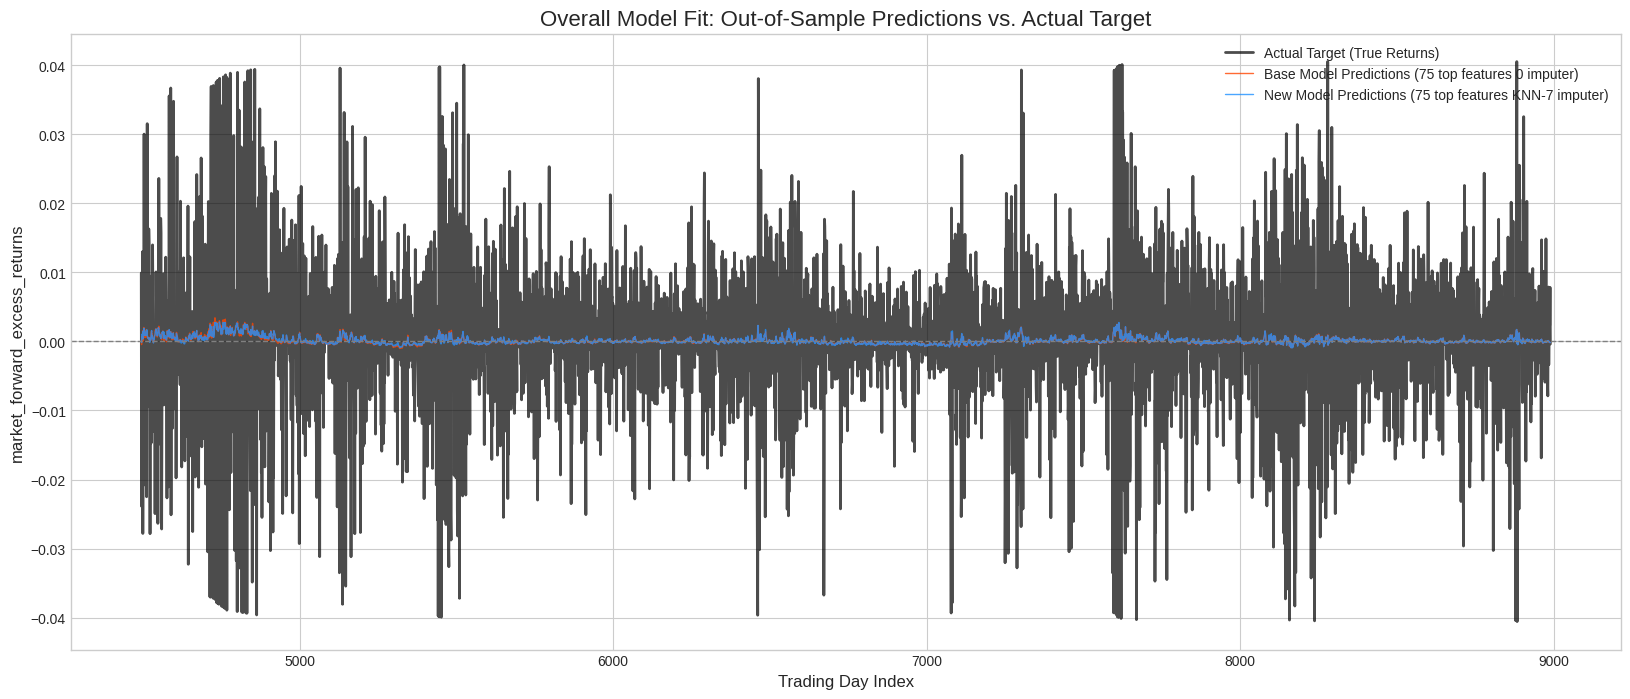


--- 正在生成累积收益拟合图 (权益曲线) ---


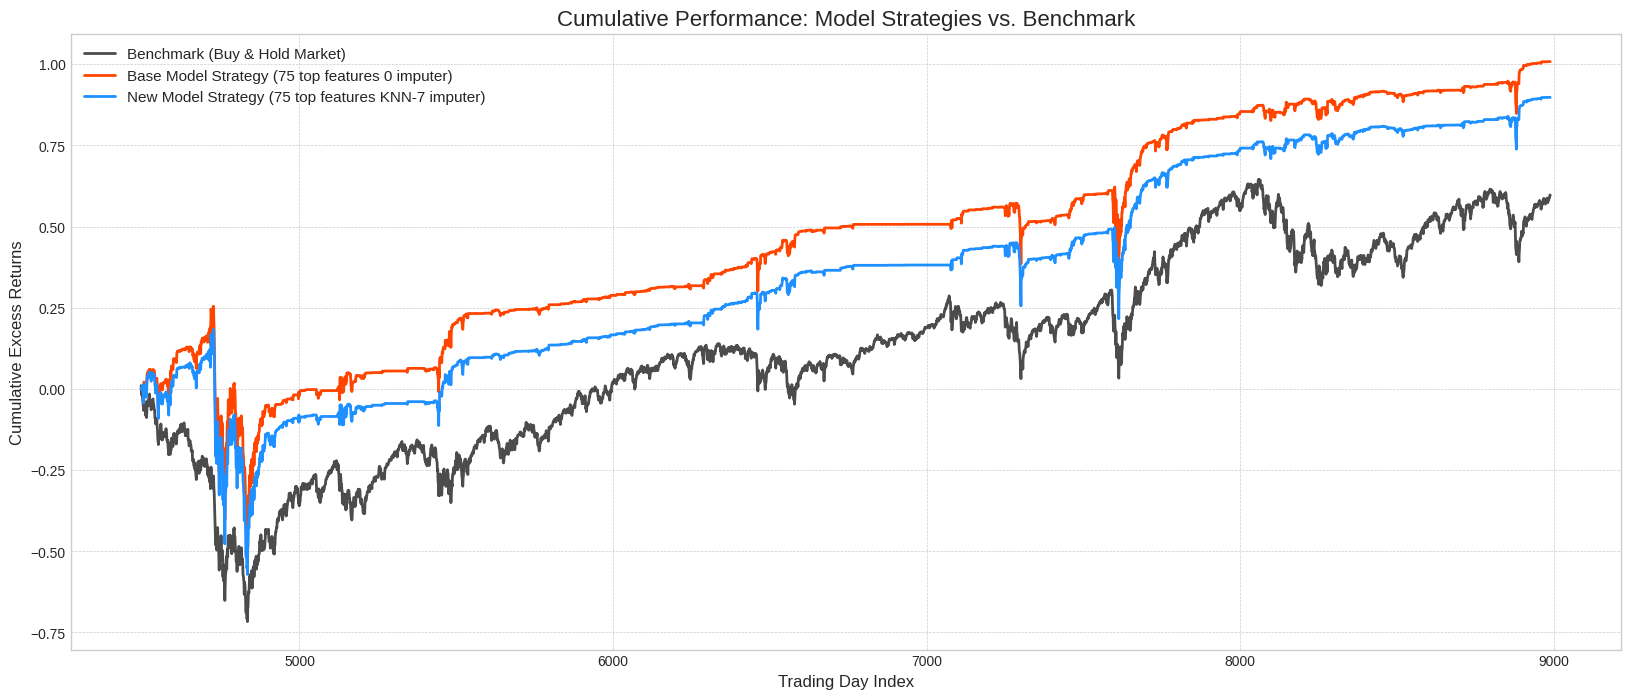

In [75]:
import matplotlib.pyplot as plt # <--- 导入 matplotlib
# --- 步骤 1 & 2: 保持不变 ---
log1 = True
log2 = True
print("数据和函数已加载。")
base_model_descirption = "75 top features 0 imputer"
new_model_descirption = "75 top features KNN-7 imputer"
ID = 9
date = "2025/10/11"

IMPUTER_PARAMETERS = {
    'n_neighbors': 7,             
    'weights': 'uniform',         # 可以是 'uniform' 或 'distance'
    'missing_values': np.nan      # 告诉 Imputer 哪些值是缺失的
}
KNN_IMPUTER = KNNImputer(**IMPUTER_PARAMETERS)

# 定义要比较的两个模型
model_base = Pipeline([
    ('feature_creator', feature_creator2),
    #('imputer', SimpleImputer(strategy='median')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('regressor', CatBoostRegressor(**Best_parameters2, verbose=0, random_seed=42))
])
model_new = Pipeline([
    ('feature_creator', feature_creator2),
    #('imputer', SimpleImputer(strategy='median')),
    ('knn_imputer', KNN_IMPUTER), 
    ('regressor', CatBoostRegressor(**Best_parameters2, verbose=0, random_seed=42))
])
print(f"实验ID：{ID}, 时间：{date}")
print(f"\n基础模型 ({base_model_descirption}) 和新模型 ({new_model_descirption}) 已定义。")

# --- 步骤 3: 执行前向展开分析 (增加预测值收集) ---

print("\n开始执行前向展开分析...")

n_samples = len(X)
initial_train_size = int(n_samples * 0.5)
test_size = int(n_samples * 0.1)

# 初始化列表以存储分数和预测结果
base_model_sharpe_scores, new_model_sharpe_scores = [], []
base_model_r2_scores, new_model_r2_scores = [], []
all_test_indices, all_y_true, all_base_preds, all_new_preds = [], [], [], []

train_start_index = 0
train_end_index = initial_train_size
test_end_index = train_end_index + test_size

while test_end_index <= n_samples:
    print(f"训练周期: index {train_start_index} to {train_end_index-1} | "
          f"测试周期: index {train_end_index} to {test_end_index-1}")

    X_train, y_train = X.iloc[train_start_index:train_end_index], y.iloc[train_start_index:train_end_index]
    X_test, y_test = X.iloc[train_end_index:test_end_index], y.iloc[train_end_index:test_end_index]

    model_base.fit(X_train, y_train)
    model_new.fit(X_train, y_train)

    preds_base = model_base.predict(X_test)
    preds_new = model_new.predict(X_test)
    
    # 收集分数
    base_model_sharpe_scores.append(ad_sharpe_ratio_scorer(model_base, X_test, y_test))
    new_model_sharpe_scores.append(ad_sharpe_ratio_scorer(model_new, X_test, y_test))
    base_model_r2_scores.append(r2_score(y_test, preds_base))
    new_model_r2_scores.append(r2_score(y_test, preds_new))
    
    # <--- 新增：收集用于绘图的数据 --- >
    all_test_indices.append(y_test.index)
    all_y_true.append(y_test.values)
    all_base_preds.append(preds_base)
    all_new_preds.append(preds_new)
    
    train_start_index += test_size
    train_end_index += test_size
    test_end_index += test_size

print("\n前向展开分析完成。")
print(f"基础模型在各周期的夏普率: {[f'{s:.4f}' for s in base_model_sharpe_scores]}， 平均日夏普率：{np.mean(base_model_sharpe_scores)}")
print(f"新模型在各周期的夏普率:   {[f'{s:.4f}' for s in new_model_sharpe_scores]}， 平均日夏普率：{np.mean(new_model_sharpe_scores)}")
print("-" * 50)
print(f"基础模型在各周期的 R²: {[f'{s:.4f}' for s in base_model_r2_scores]}， 平均R2：{np.mean(base_model_r2_scores)}")
print(f"新模型在各周期的 R²:   {[f'{s:.4f}' for s in new_model_r2_scores]}， 平均R2：{np.mean(new_model_r2_scores)}")

# --- 步骤 4: t检验 (保持不变) ---
'''
print("\n--- 执行配对t检验 (基于夏普率) ---")
if len(base_model_sharpe_scores) > 2:
    t_stat_sharpe, p_val_sharpe = stats.ttest_rel(new_model_sharpe_scores, base_model_sharpe_scores, alternative='greater')
    print(f"T-statistic: {t_stat_sharpe:.4f}")
    print(f"P-value: {p_val_sharpe:.4f}")
    alpha = 0.05
    if p_val_sharpe < alpha:
        print("结论: 在夏普率方面，新模型(中位数填充)的提升在统计上是显著的。")
    else:
        print("结论: 在夏普率方面，新模型(中位数填充)的提升不具备统计显著性。")
else:
    print("测试周期太少，无法进行有效的t检验。")

# --- 4b. 针对R²的t检验 ---
print("\n--- 执行配对t检验 (基于 R²) ---")
if len(base_model_r2_scores) > 2:
    t_stat_r2, p_val_r2 = stats.ttest_rel(new_model_r2_scores, base_model_r2_scores, alternative='greater')
    print(f"T-statistic: {t_stat_r2:.4f}")
    print(f"P-value: {p_val_r2:.4f}")
    alpha = 0.05
    if p_val_r2 < alpha:
        print("结论: 在 R² 方面，新模型(中位数填充)的预测准确性提升在统计上是显著的。")
    else:
        print("结论: 在 R² 方面，新模型(中位数填充)的预测准确性提升不具备统计显著性。")
else:
    print("测试周期太少，无法进行有效的t检验。")
'''
# --- 步骤 5: 拼接数据并绘制总体拟合图 ---

print("\n--- 正在生成总体拟合图 ---")

# 1. 将所有周期的测试数据拼接成一个连续的序列
if all_test_indices:
    combined_indices = np.concatenate(all_test_indices)
    combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
    combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds (fill 0)")
    combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds (median)")

    # 2. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 3. 绘制真实值和两个模型的预测值
    plt.plot(combined_y_true, label='Actual Target (True Returns)', color='black', linewidth=2, alpha=0.7)
    plt.plot(combined_base_preds, label=f'Base Model Predictions ({base_model_descirption})', color='orangered', linewidth=1, alpha=0.8)
    plt.plot(combined_new_preds, label=f'New Model Predictions ({new_model_descirption})', color='dodgerblue', linewidth=1, alpha=0.8)

    # 4. 添加图表元素
    plt.title('Overall Model Fit: Out-of-Sample Predictions vs. Actual Target', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel(f'{TARGET}', fontsize=12)
    plt.legend(fontsize=10)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1) # 添加0线作为参考
    
    # 5. 显示图表
    plt.show()
else:
    print("没有可用于绘图的预测数据。")
    
print("\n--- 正在生成累积收益拟合图 (权益曲线) ---")

if all_test_indices:
    # 1. 拼接数据 (如果尚未拼接)
    if 'combined_y_true' not in locals():
        combined_indices = np.concatenate(all_test_indices)
        combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
        combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds")
        combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds")

    # 2. 计算每个周期的策略收益
    # 基准策略: 买入并持有市场 (收益就是真实的目标值)
    benchmark_returns = combined_y_true
    
    # 基础模型策略收益 (根据 sharpe_ratio_scorer 的逻辑)
    base_positions = np.where(combined_base_preds > 0, combined_base_preds*1000, 0)
    base_positions = np.clip(base_positions, 0, 2)
    base_strategy_returns = pd.Series(base_positions*benchmark_returns.values, index=benchmark_returns.index)
    
    # 新模型策略收益
    new_positions = np.where(combined_new_preds > 0, combined_new_preds*1000, 0)
    new_positions = np.clip(new_positions, 0, 2)
    new_strategy_returns = pd.Series(new_positions*benchmark_returns.values, index=benchmark_returns.index)

    # 3. 计算累积收益 (权益曲线)
    cumulative_benchmark = benchmark_returns.cumsum()
    cumulative_base_strategy = base_strategy_returns.cumsum()
    cumulative_new_strategy = new_strategy_returns.cumsum()

    # 4. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 5. 绘制三条累积收益曲线
    plt.plot(cumulative_benchmark, label='Benchmark (Buy & Hold Market)', color='black', linewidth=2, alpha=0.7)
    plt.plot(cumulative_base_strategy, label=f'Base Model Strategy ({base_model_descirption})', color='orangered', linewidth=2)
    plt.plot(cumulative_new_strategy, label=f'New Model Strategy ({new_model_descirption})', color='dodgerblue', linewidth=2)
    
    # 6. 添加图表元素
    plt.title('Cumulative Performance: Model Strategies vs. Benchmark', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel('Cumulative Excess Returns', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # 7. 显示图表
    plt.show()